In [50]:

import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os
import pandas as pd
from shapely.geometry import Point, Polygon
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from matplotlib_scalebar.scalebar import ScaleBar

### Purpose and Description of this Notebook:
This notebook aims to clean and preprocess the Ethiopian Health Facilities dataset Ethiopian Health Facilities.shp.
The cleaning process involves handling missing values, standardizing text fields, and removing duplicates to ensure data consistency and quality.
Additionally, this notebook merges the cleaned Ethiopian Health Facilities dataset with the AddisDatabase AddisDatabase.shp.
The merged dataset will provide a comprehensive view of health facilities in Ethiopia, particularly in Addis Ababa, enabling more accurate analysis and decision-making.


# Data Cleaning
This section handles the cleaning and preprocessing of the Ethiopian health facilities dataset including handling missing values, standardizing text fields, and removing duplicates


In [51]:
# Load the data
ethiopia_health = gpd.read_file('./Ethiopian_health_Facilities/Ethiopian Health Facilities.shp')


# Filter the data to include only Addis Ababa
addis_ababa_health = ethiopia_health[ethiopia_health['admin1Name'] == 'Addis Ababa']

# Clean the data
# 1. Remove rows with missing critical information
addis_ababa_health = addis_ababa_health.dropna(subset=['Type', 'admin1Name', 'Ownership'])

# 2. Standardize text columns
# List of text columns to standardize
text_columns = ['Type', 'admin1Name', 'admin2Name', 'Name', 'admin3Name', 'City', 'Kebele', 'Ownership']

# Standardize each text column
for col in text_columns:
    # Apply basic string cleaning (strip whitespace) to all columns
    addis_ababa_health[col] = addis_ababa_health[col].str.strip()
    # addis_ababa_health[col] = addis_ababa_health[col].str.title()
    
    
    
# 3. Create health facility counts by administrative levels
# Check for duplicates and drop them, keeping only unique entries
duplicate_check = addis_ababa_health.duplicated(keep=False)
if duplicate_check.any():
    print(f"Found and removing {duplicate_check.sum()} duplicate entries")
    # Drop duplicates and keep first occurrence
    addis_ababa_health = addis_ababa_health.drop_duplicates(keep='first')
    print(f"Remaining unique entries: {len(addis_ababa_health)}")

# Create health facility counts
health_counts = addis_ababa_health.groupby(['Type', 'admin1Name', 'admin2Name', 'admin3Name'])\
    .size()\
    .reset_index(name='health_institution_count')\
    .sort_values('health_institution_count', ascending=False)

# 4. Create ownership distribution
ownership_counts = addis_ababa_health.groupby(['admin1Name', 'Ownership'])\
    .size()\
    .reset_index(name='ownership_count')\
    .sort_values('ownership_count', ascending=False)




In [52]:
# Load Addis Ababa shapefile
addis_db = gpd.read_file('../AddisDatabase.shp')

# Drop rows with missing Woreda values
addis_db = addis_db.dropna(subset=['Woreda'])

# Check for duplicates and drop them
duplicate_check = addis_db.duplicated(keep=False)
if duplicate_check.any():
    print(f"Found and removing {duplicate_check.sum()} duplicate entries")
    # Drop duplicates and keep first occurrence
    addis_db = addis_db.drop_duplicates(keep='first')
    print(f"Remaining unique entries: {len(addis_db)}")

# Convert CRS to EPSG:4326 (WGS84)
addis_db = addis_db.to_crs(epsg=4326)

In [53]:

addis_health_merged = gpd.sjoin(addis_db, addis_ababa_health, how='left', predicate='intersects')

In [54]:
addis_health_merged = addis_health_merged[['Woreda', 'Sub_City', 'popden', 'Area', 'Name', 'Ownership', 'Type', 'Status', 'geometry']]

# Data Engineering 
Here we create additional columns of number of health institutions by type, ownership, and status



In [8]:
# Step 1: Count total number of health institutions by Sub_City and Woreda
count_total = addis_health_merged.groupby(['Woreda', 'Sub_City', 'popden', 'Area', 'geometry']).size().reset_index(name='number_of_health_inst')

# Step 2: Pivot Ownership, Type, and Status into counts
pivot_ownership = pd.pivot_table(addis_health_merged, index=['Woreda', 'Sub_City', 'popden', 'Area', 'geometry'], columns='Ownership', aggfunc='size', fill_value=0)
pivot_type = pd.pivot_table(addis_health_merged, index=['Woreda', 'Sub_City', 'popden', 'Area', 'geometry'], columns='Type', aggfunc='size', fill_value=0)
pivot_status = pd.pivot_table(addis_health_merged, index=['Woreda', 'Sub_City', 'popden', 'Area', 'geometry'], columns='Status', aggfunc='size', fill_value=0)

# Step 3: Combine all into a condensed dataset
condensed_df = count_total \
    .set_index(['Woreda', 'Sub_City', 'popden', 'Area', 'geometry']) \
    .join([pivot_ownership, pivot_type, pivot_status]) \
    .reset_index()


# Data Data Visualization
Task for Tarik- Here we map the popdn heat map by placing the rank of each of the number of institutions columns including popden at subcity and woreda level. So you basically produce 2 maps one at sub_city and another at woreda level that summarize the heat map of pop_den and the number of institutions in a form of ranking.


# Health Institution Type Counts in Addis Ababa

This script visualizes the distribution of health institution types in Addis Ababa using a bar plot.

### Key Steps:

1. **Data Preparation**  
   - Counts the number of each type of health institution in the dataset.  
   - Sorts these counts in descending order to highlight the most prevalent types.

2. **Visualization**  
   - Creates a bar plot showing the counts of each institution type.  
   - Adds descriptive titles and axis labels for clarity.  
   - Rotates the x-axis labels for better readability.

### Purpose:

This bar chart provides a quick visual summary of how different types of health institutions are distributed in Addis Ababa, making it easier to identify which types are most or least common.

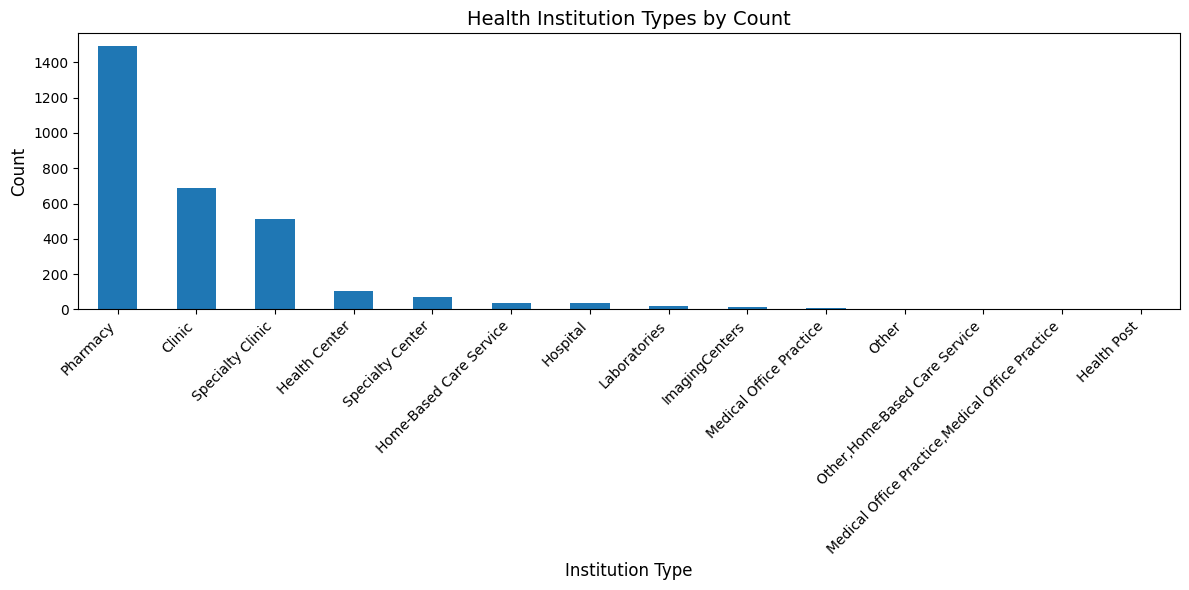

In [96]:
# Count health institution types and sort in descending order
health_type_counts = addis_health_merged['Type'].value_counts().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
health_type_counts.plot(kind='bar')
plt.title('Health Institution Types by Count', fontsize=14)
plt.xlabel('Institution Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()



plt.show()


# Population Density and Dominant Health Institution Types in Addis Ababa

This script visualizes two key aspects of Addis Ababa's woredas side by side:

### Key Steps:

1. **Create a Figure with Two Subplots**  
   - **First subplot**: Displays population density.  
   - **Second subplot**: Shows the dominant health institution type (excluding pharmacies).

2. **First Subplot: Population Density**  
   - Uses a red color gradient to map the population density (`popden`) of each woreda.  
   - Labels each woreda with its name and subcity.  
   - Adds a scalebar for spatial context.

3. **Second Subplot: Dominant Health Institution Type**  
   - Filters out pharmacies to focus on hospitals, clinics, and laboratories.  
   - Determines the dominant type of health facility in each woreda (the most frequent type).  
   - Colors each woreda according to its dominant type.  
   - Labels each woreda with its name and the dominant institution type for clarity.  
   - Adds a scalebar and legend to aid interpretation.

### Purpose:

This dual-visualization map offers insights into how population density and the dominant type of health institution align in Addis Ababa. It supports urban health infrastructure planning by identifying potential mismatches between population needs and the types of health facilities present in each woreda.

/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


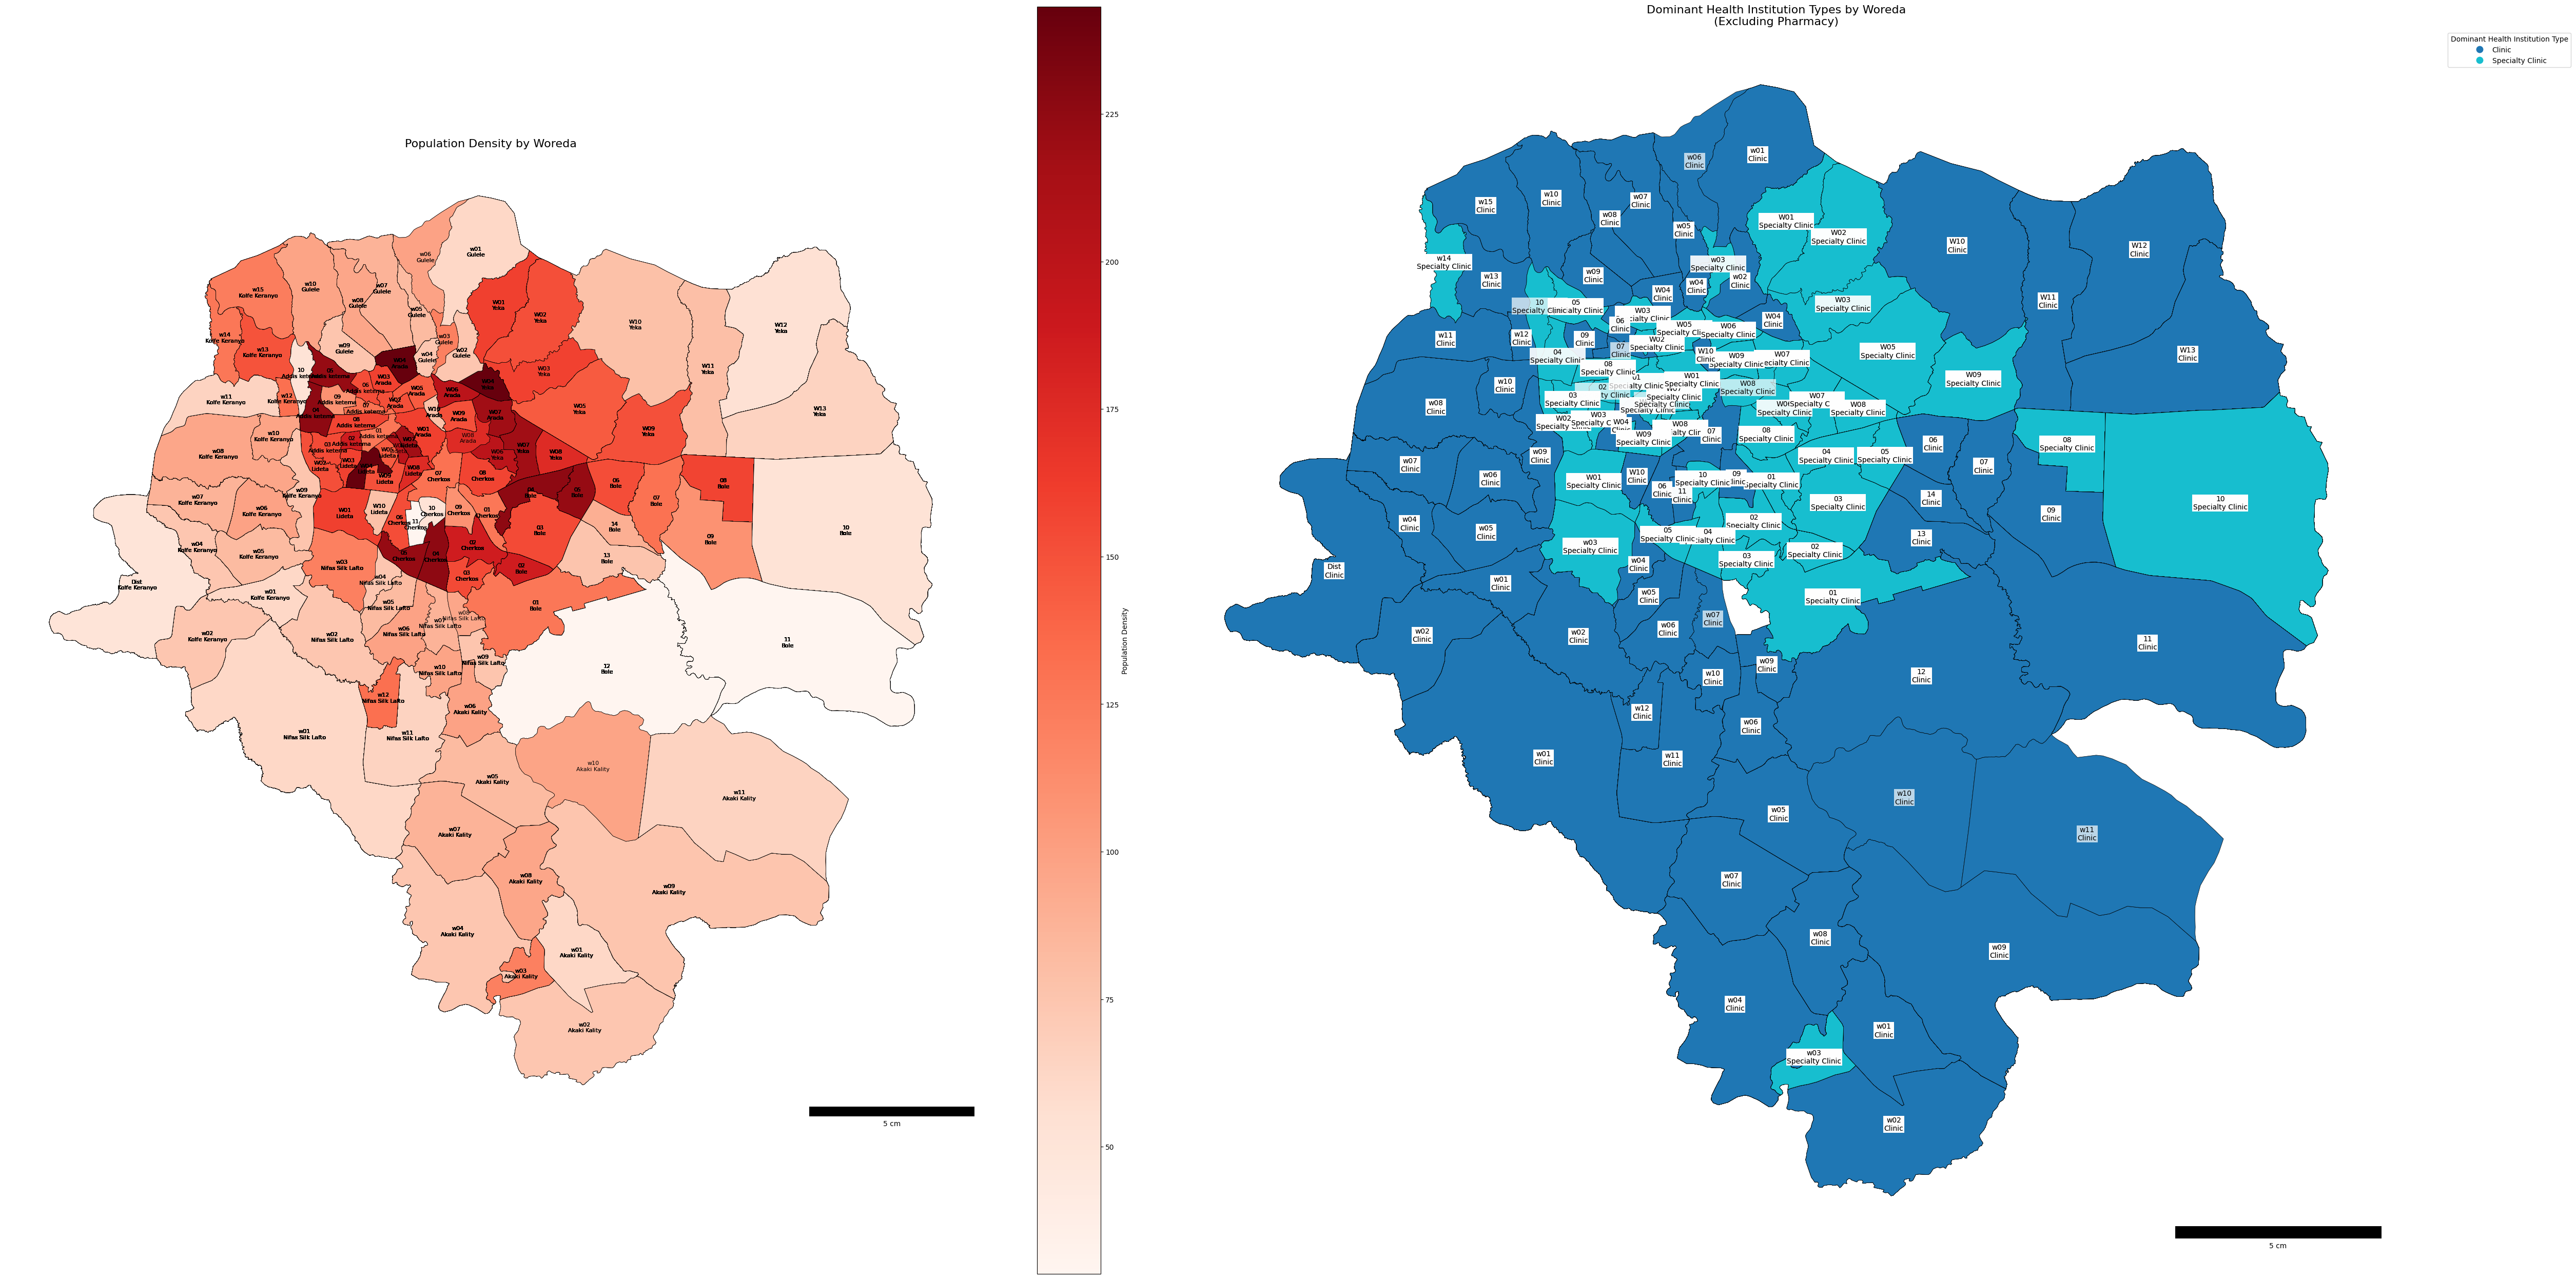

In [75]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 25))

# --- First subplot: Population Density ---
addis_health_merged.plot(
    column='popden',
    ax=ax1,
    legend=True,
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Population Density'}
)

# Add labels for each woreda
for idx, row in addis_health_merged.iterrows():
    centroid = row.geometry.centroid
    ax1.text(
        centroid.x, 
        centroid.y, 
        f"{row['Woreda']}\n{row['Sub_City']}", 
        fontsize=8,
        ha='center',
        va='center'
    )

ax1.set_title('Population Density by Woreda', fontsize=16)
ax1.set_axis_off()
scalebar1 = ScaleBar(1, location='lower right')
ax1.add_artist(scalebar1)

# --- Second subplot: Dominant Health Institution Types ---
# Filter out pharmacy and get remaining institution types
filtered_df = addis_health_merged[addis_health_merged['Type'] != 'Pharmacy'].copy()

# Create a new column for dominant type by counting occurrences in each woreda
woreda_type_counts = filtered_df.groupby(['Woreda', 'Type']).size().reset_index(name='count')
dominant_types = woreda_type_counts.sort_values('count', ascending=False).groupby('Woreda').first()
filtered_df['dominant_type'] = filtered_df['Woreda'].map(dominant_types['Type'])

# Plot dominant types with improved styling
filtered_df.plot(
    column='dominant_type',
    ax=ax2,
    legend=True,
    categorical=True,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={
        'title': 'Dominant Health Institution Type',
        'bbox_to_anchor': (1.05, 1),
        'loc': 'upper left'
    }
)

# Add labels for each woreda with improved readability
for idx, row in filtered_df.iterrows():
    centroid = row.geometry.centroid
    ax2.text(
        centroid.x, 
        centroid.y, 
        f"{row['Woreda']}\n{row['dominant_type']}", 
        fontsize=10,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

ax2.set_title('Dominant Health Institution Types by Woreda\n(Excluding Pharmacy)', fontsize=16)
ax2.set_axis_off()
scalebar2 = ScaleBar(1, location='lower right')
ax2.add_artist(scalebar2)

plt.tight_layout()
plt.show()



# Health Facility Distribution Map for Addis Ababa

This script creates a single, comprehensive map displaying the distribution and ranking of health facilities (excluding pharmacies) across all woredas in Addis Ababa.

### Key Steps:

1. **Data Filtering**  
   - Excludes pharmacies to focus on hospitals, clinics, and laboratories.

2. **Facility Count and Ranking**  
   - Calculates the count of hospitals, clinics, and laboratories for each woreda.
   - Computes an overall count of health facilities for each woreda.
   - Calculates separate rankings for:
     - Hospitals
     - Clinics
     - Laboratories
     - Overall total of facilities

3. **Visualization**  
   - Generates a single map covering the entire city.
   - Uses a color gradient (Red-Yellow-Green) to indicate the total number of health facilities in each woreda.
   - Labels each woreda with detailed information:
     - Woreda name and subcity.
     - Overall rank.
     - Counts and ranks for hospitals, clinics, and laboratories.
   - Dynamically adjusts label backgrounds for readability:
     - White if the total facility count is above the city median.
     - Red if below the median.
   - Adds a scalebar for spatial context.

### Purpose:

This script provides a detailed, citywide overview of health facility distribution and rankings in Addis Ababa. It enables stakeholders to identify disparities, prioritize resource allocation, and plan interventions more effectively.

/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


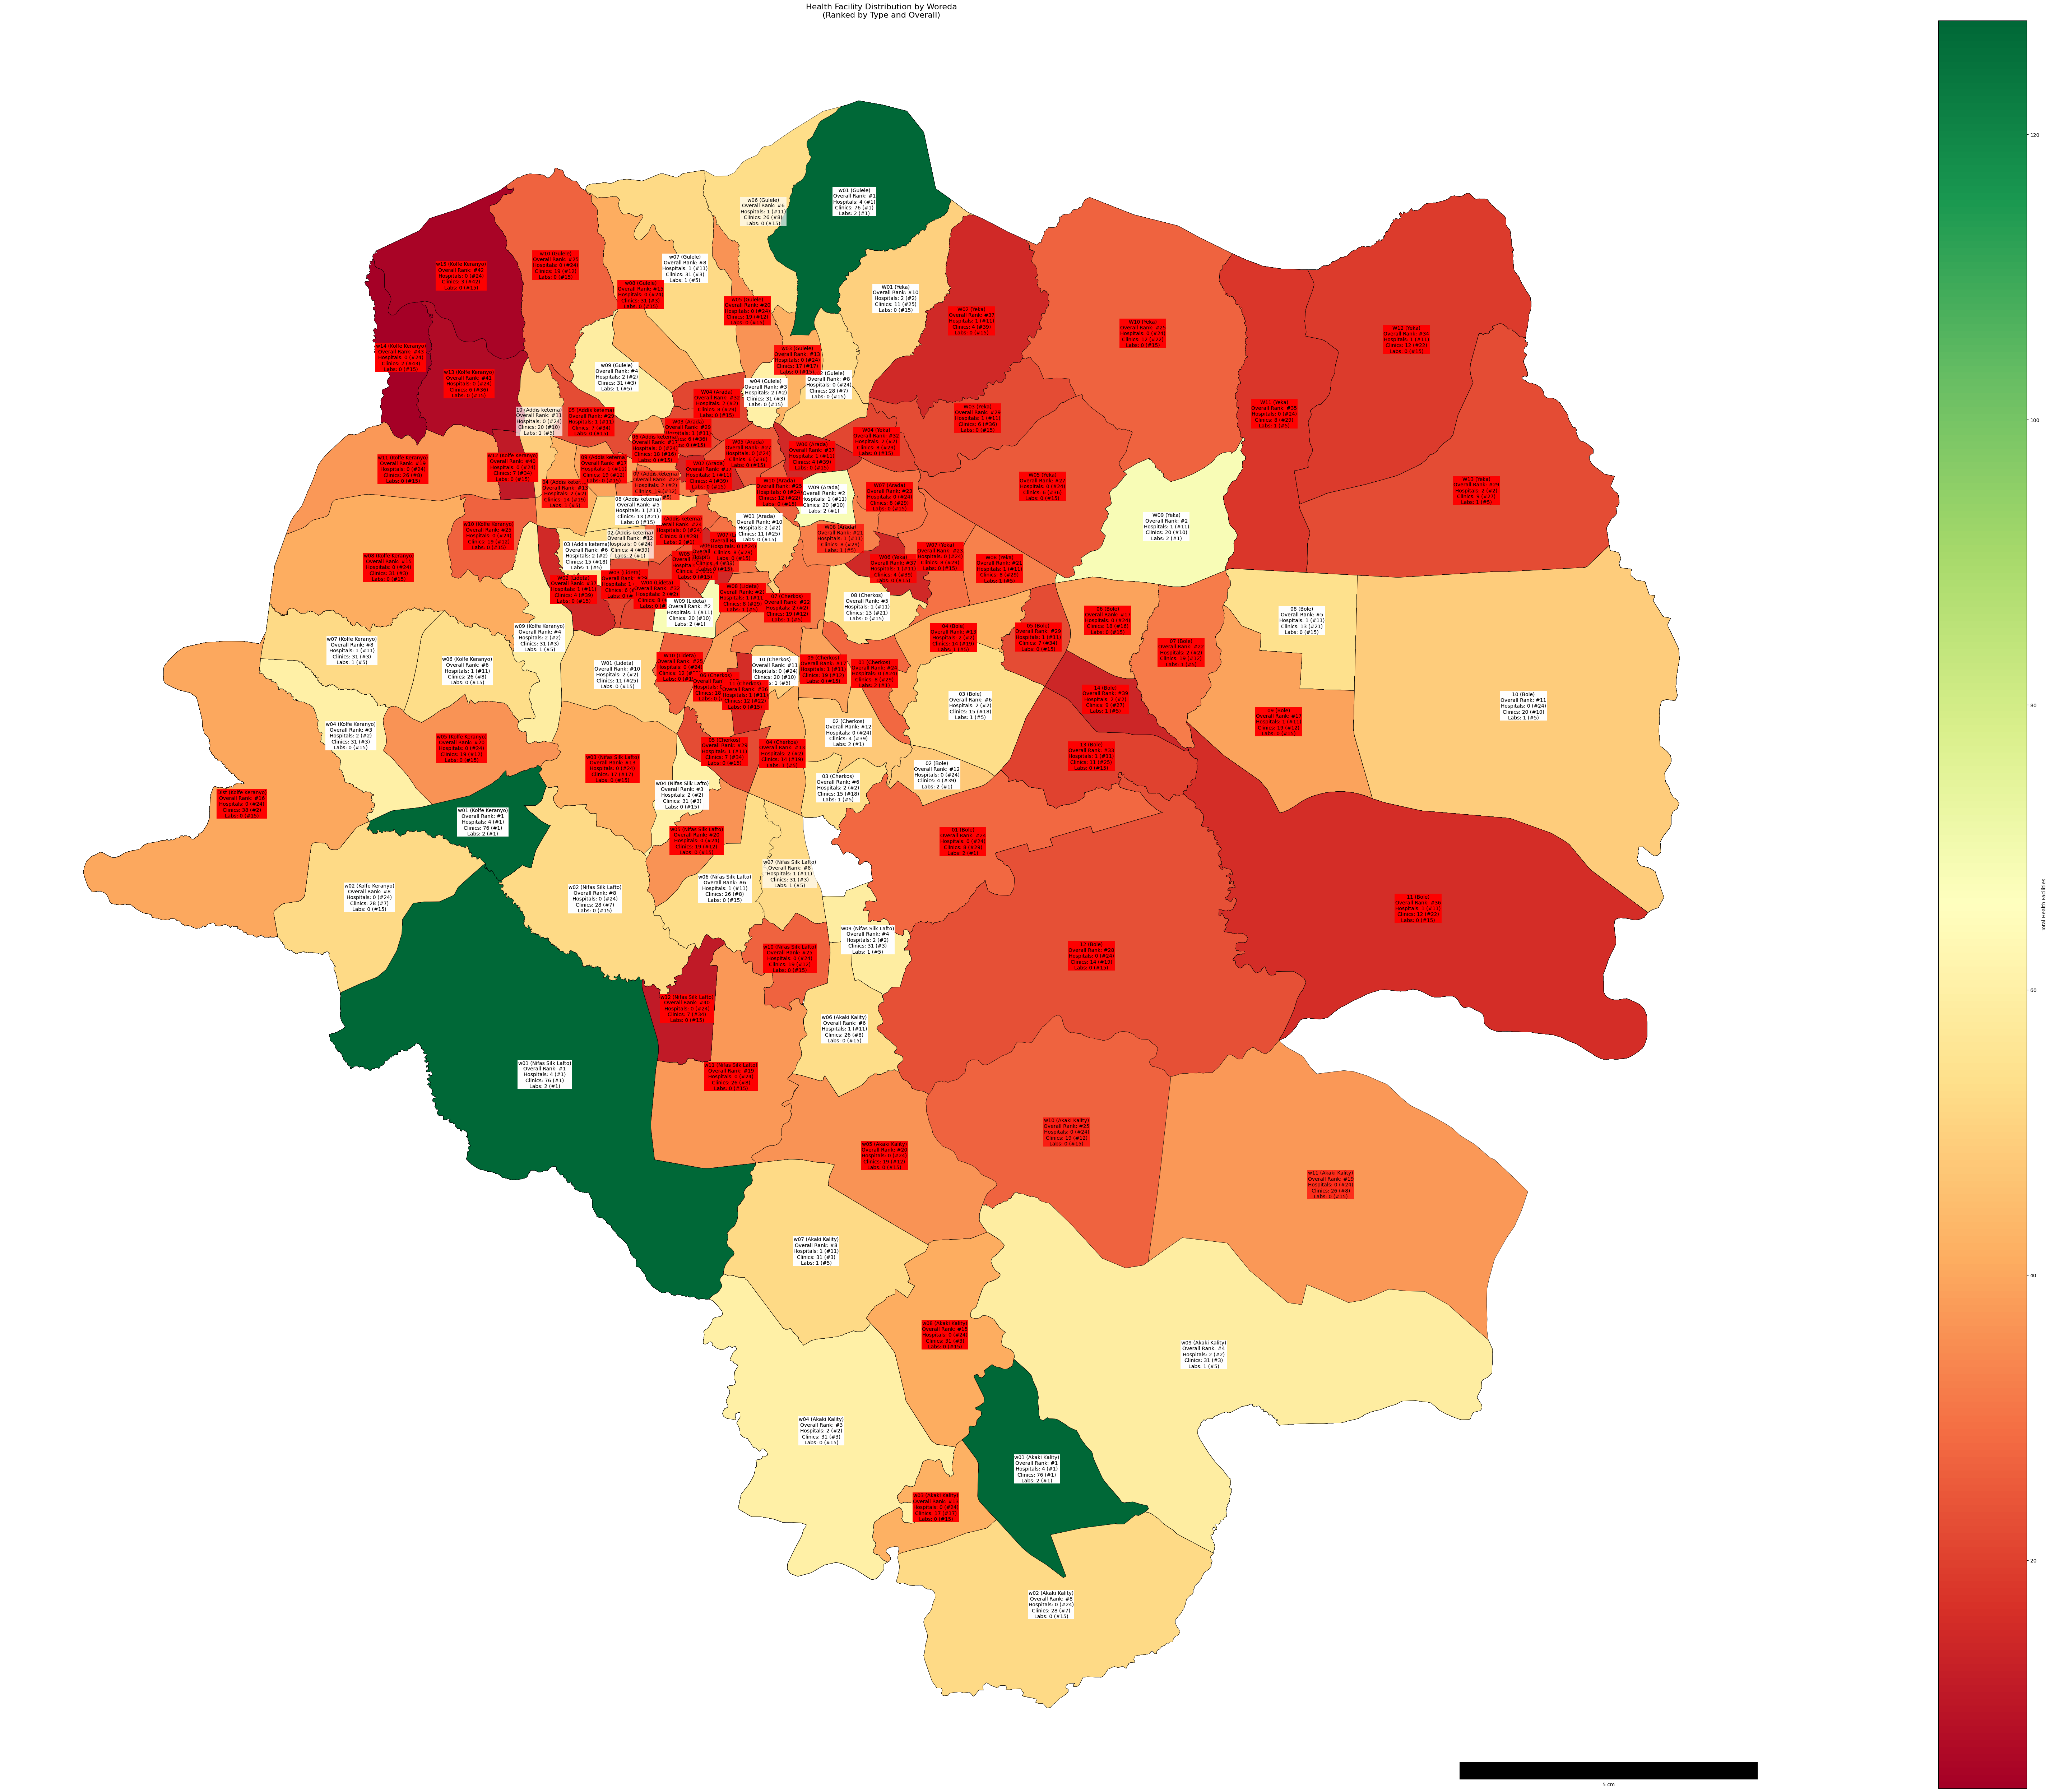

In [87]:
filtered_df = addis_health_merged[addis_health_merged['Type'] != 'Pharmacy'].copy()
# Create a single figure without subplots
fig = plt.figure(figsize=(100, 50))
ax = fig.add_subplot(111)

# Calculate counts for each facility type by woreda
woreda_counts = filtered_df.groupby(['Woreda', 'Type']).size().unstack(fill_value=0)
woreda_counts['total'] = woreda_counts.sum(axis=1)

# Create rankings for each type and overall ranking
woreda_counts['hospital_rank'] = woreda_counts['Hospital'].rank(ascending=False, method='min')
woreda_counts['clinic_rank'] = woreda_counts['Clinic'].rank(ascending=False, method='min')
woreda_counts['lab_rank'] = woreda_counts['Laboratories'].rank(ascending=False, method='min')
woreda_counts['overall_rank'] = woreda_counts['total'].rank(ascending=False, method='min')

# Merge rankings back to filtered_df
filtered_df = filtered_df.merge(woreda_counts[['hospital_rank', 'clinic_rank', 'lab_rank', 'overall_rank', 'total']], 
                              left_on='Woreda', right_index=True)

# Create color mapping based on total facilities
max_total = filtered_df['total'].max()
filtered_df['color_intensity'] = filtered_df['total'] / max_total

# Plot with color gradient
filtered_df.plot(
    column='total',
    ax=ax,
    legend=True,
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={
        'label': 'Total Health Facilities',
        'orientation': 'vertical'
    }
)

# Add detailed labels for each woreda
for idx, row in filtered_df.iterrows():
    centroid = row.geometry.centroid
    label_text = (
        f"{row['Woreda']} ({row['Sub_City']})\n"  # Added Sub_City name
        f"Overall Rank: #{int(row['overall_rank'])}\n"
        f"Hospitals: {woreda_counts.loc[row['Woreda'], 'Hospital']} (#{int(row['hospital_rank'])})\n"
        f"Clinics: {woreda_counts.loc[row['Woreda'], 'Clinic']} (#{int(row['clinic_rank'])})\n"
        f"Labs: {woreda_counts.loc[row['Woreda'], 'Laboratories']} (#{int(row['lab_rank'])})"
    )
    
    # Adjust background color based on total facilities
    bg_color = 'white' if row['total'] > filtered_df['total'].median() else 'red'
    
    ax.text(
        centroid.x, 
        centroid.y, 
        label_text,
        fontsize=10,
        ha='center',
        va='center',
        bbox=dict(
            facecolor=bg_color,
            alpha=0.7,
            edgecolor='none',
            pad=1
        )
    )

ax.set_title('Health Facility Distribution by Woreda\n(Ranked by Type and Overall)', fontsize=16)
ax.set_axis_off()
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()


# Health Facility Distribution Analysis in Addis Ababa

This script analyzes and visualizes the distribution of health facilities (excluding pharmacies) in Addis Ababa at the woreda and subcity levels.

### Key Steps:

1. **Data Filtering**  
   - Removes pharmacies from the dataset.
   - Focuses only on hospitals, clinics, and laboratories.

2. **Facility Count and Ranking**  
   - Calculates the number of hospitals, clinics, and laboratories in each woreda.
   - Computes an overall count of facilities in each woreda.
   - Ranks each woreda separately by the number of hospitals, clinics, labs, and also by the overall count.

3. **Visualization**  
   - Generates a subplot for each subcity in Addis Ababa.
   - Each subplot shows:
     - A color gradient map based on the total number of health facilities in each woreda.
     - Labels for each woreda, displaying:
       - Woreda name.
       - Overall rank.
       - Counts and ranks for hospitals, clinics, and laboratories.
     - Labels have dynamic backgrounds (white or red) depending on whether the total count is above or below the median, to enhance readability.
   - Adds a scalebar to each subplot for spatial reference.

### Purpose:

This script helps visualize and identify disparities in health facility distribution across Addis Ababa, aiding data-driven decision-making and resource planning.

/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call

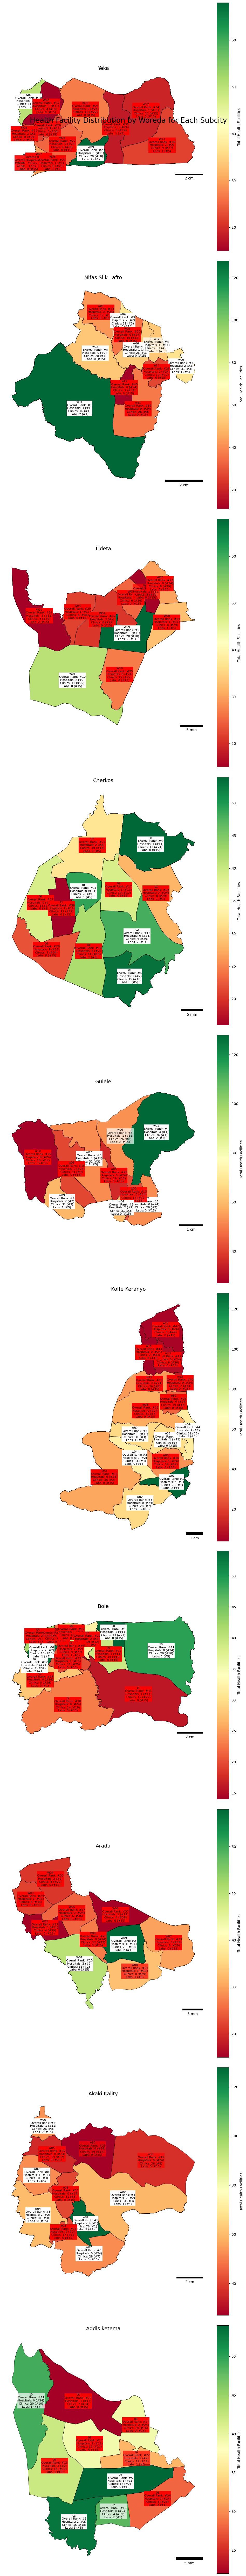

In [95]:
# Filter out pharmacies
filtered_df = addis_health_merged[addis_health_merged['Type'] != 'Pharmacy'].copy()

# Get unique subcities
subcities = filtered_df['Sub_City'].unique()

# Calculate counts for each facility type by woreda
woreda_counts = filtered_df.groupby(['Woreda', 'Type']).size().unstack(fill_value=0)
woreda_counts['total'] = woreda_counts.sum(axis=1)

# Create rankings for each type and overall ranking
woreda_counts['hospital_rank'] = woreda_counts['Hospital'].rank(ascending=False, method='min')
woreda_counts['clinic_rank'] = woreda_counts['Clinic'].rank(ascending=False, method='min')
woreda_counts['lab_rank'] = woreda_counts['Laboratories'].rank(ascending=False, method='min')
woreda_counts['overall_rank'] = woreda_counts['total'].rank(ascending=False, method='min')

# Merge rankings back to filtered_df
filtered_df = filtered_df.merge(woreda_counts[['hospital_rank', 'clinic_rank', 'lab_rank', 'overall_rank', 'total']], 
                              left_on='Woreda', right_index=True)

# Create a figure with subplots for each subcity
fig = plt.figure(figsize=(10, 10*len(subcities)))
fig.suptitle('Health Facility Distribution by Woreda for Each Subcity', fontsize=20, y=0.95)

# Plot each subcity in a separate subplot
for idx, subcity in enumerate(subcities, 1):
    ax = fig.add_subplot(len(subcities), 1, idx)
    
    # Filter data for current subcity
    subcity_df = filtered_df[filtered_df['Sub_City'] == subcity].copy()
    
    # Plot with color gradient
    subcity_df.plot(
        column='total',
        ax=ax,
        legend=True,
        cmap='RdYlGn',
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={
            'label': 'Total Health Facilities',
            'orientation': 'vertical'
        }
    )
    
    # Add detailed labels for each woreda in the subcity
    for _, row in subcity_df.iterrows():
        centroid = row.geometry.centroid
        label_text = (
            f"{row['Woreda']}\n"
            f"Overall Rank: #{int(row['overall_rank'])}\n"
            f"Hospitals: {woreda_counts.loc[row['Woreda'], 'Hospital']} (#{int(row['hospital_rank'])})\n"
            f"Clinics: {woreda_counts.loc[row['Woreda'], 'Clinic']} (#{int(row['clinic_rank'])})\n"
            f"Labs: {woreda_counts.loc[row['Woreda'], 'Laboratories']} (#{int(row['lab_rank'])})"
        )
        
        # Adjust background color based on total facilities
        bg_color = 'white' if row['total'] > filtered_df['total'].median() else 'red'
        
        ax.text(
            centroid.x, 
            centroid.y, 
            label_text,
            fontsize=8,
            ha='center',
            va='center',
            bbox=dict(
                facecolor=bg_color,
                alpha=0.7,
                edgecolor='none',
                pad=1
            )
        )
    
    ax.set_title(f'{subcity}', fontsize=14)
    ax.set_axis_off()
    scalebar = ScaleBar(1, location='lower right')
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()
